# Theory

## English Algorithm

1. For each instance, count the number of instances around it within some distance $\epsilon$. Call this region $\epsilon$-neighborhood.
2. If an instance has at least `min_samples` within its neighborhood, then this sample becomes labeled as a core instance. Core instances are therefore ususally a part of dense kind of regions.
3. If a instances, or a core instance is part of the same core neighborhood, then it forms a cluster. Because core instances can chain, this forms a sequence of core instance than can form an arbitrary cluster shape. Any instance that does not fall into the neighborhood of a core instance is known as an anomaly.

**Sample Demo**

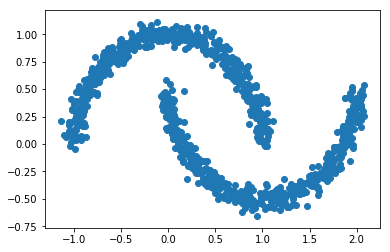

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
plt.scatter(X[:,0], X[:,1])

In [2]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
unique_labels = set(dbscan.labels_)
unique_labels

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

Note here that samples that are -1, are anomaly classifications. Also notice that there are many labels, implying that the classification performed poorly.

## Characteristics

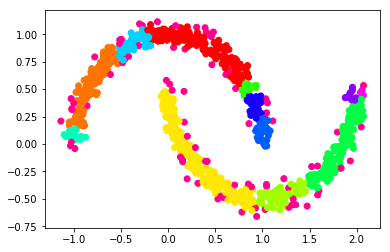

In [3]:
from mltoolbox.draw.color import map_labels_to_random_color

plt.scatter(X[:,0], X[:,1], c=map_labels_to_random_color(dbscan.labels_))

As we can see, the algorithm with `min_samples` of 5 behaviors sort of well, but we can also identify several anomaly classifications can be occupied if we decrease the constrain on the core instances.

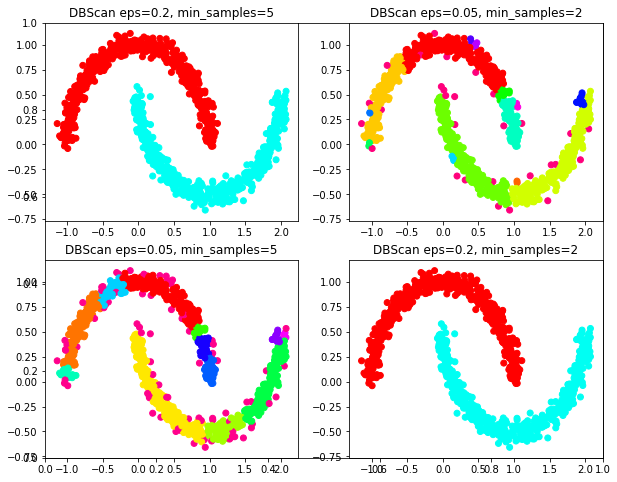

In [19]:
from mltoolbox.utils.iterables import all_parameter_wise_combinations


all_param_combs = all_parameter_wise_combinations(eps=[.2, .05], min_samples=[2, 5])
f, main_ax = plt.subplots(figsize=(10,8))
r, c = 2, 2
for i, params in enumerate(all_param_combs, 0):
    dbscan = DBSCAN(**params)
    dbscan.fit(X)
    ax = f.add_subplot(f'{r}{c}{i}')
    plt.scatter(X[:,0], X[:,1], c=map_labels_to_random_color(dbscan.labels_))
    ax.title.set_text('DBScan eps={eps}, min_samples={min_samples}'.format(**params))


From the plots above we notice the following this:
* `eps` controls the radius around each instance that qualifies it as a core instance. In any case were the eps is high, the more likely it will include other instances and therefore become a core instance acknowledged by `min_samples`
* And when `min_samples` is higher, this constrains the number of samples required in order for an instance to become a core instance. So in these cases, a high `min_samples` ususally learns to an increase of segmented clusters.


**Making Predictions**

To make predictions, it is nessessary to use a different classification in place of it. KNN for example is a supervised algorithm that requires labeled instance. Using our current data, `X` or `dbscan.components_` and `y` or `dbscan.labels_[dbscan.core_sample_indices_]`, we can train a supervised learning algorithm build on top of a unsupervised algorithm.

Note that actually `X` and `y` here are trained only on a the core components, but this is usually a good idea as it naturally removes outliers from the equation. 

In [26]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

dbscan_best = DBSCAN(eps=.2, min_samples=3)
dbscan_best.fit(X)
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan_best.components_, dbscan_best.labels_[dbscan_best.core_sample_indices_])
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([0, 1, 0, 1])

And because we can make predictions now, we form a natural classification boundary.

Text(0.5, 1.0, 'KNN Trained on Top on DBScan Unsupervised Algorithm')

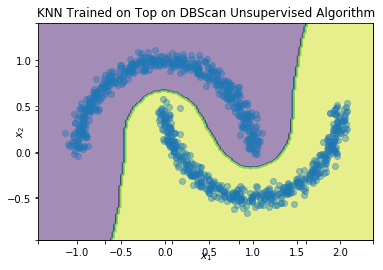

In [31]:
from mltoolbox.draw.classification import plot_2d_decision_boundary_unsupervised


diff = .3
plot_2d_decision_boundary_unsupervised([knn], X, (min(X[:,0]) - diff, max(X[:,0]) + diff),
                                       (min(X[:,1]) - diff, max(X[:,1]) + diff), 200, 200)
plt.title('KNN Trained on Top on DBScan Unsupervised Algorithm')

## Limitations

* Because the algorithm relies upon a fixed `min_samples` and `eps` distances, it does not capture very well clusters of varing density. In these cases, a transition from a low density region to a higher density region would ususally cause a partition in the clusters.
* Computational complexity is O(mlogm) where m in the number of instances.
* Memory intensive if `eps` is large.